# Analyse Event of G-ring Data

An earthquake in 2024 is analysed using the G-ring laser rotation data for the vertical component (thus only for Love waves), which are availible via FDSN services online.

In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime
from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results
from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_cwt_all import plot_cwt_all

## Configurations

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2024-12-05 18:44:21",  # Start time
    'tend': "2024-12-05 20:44:21",  # End time

    # event
    'origin_time': "2024-12-05 18:44:26",
    'magnitude': 7.0,

    # SEED identifiers
    'seed': "XX.RLAS..",     # seed ID of output stream
    'rot_seed': ["BW.RLAS..BJZ"], # Rotation sensor seed ID
    'tra_seed': ["GR.WET..BHZ", "GR.WET..BHN", "GR.WET..BHE"],  # Translation sensor seed ID
    
    # rotate to ZNE
    'rotate_to_zne': False,

    # Data source
    'data_source': "fdsn",  # "fdsn" | "sds" | "mseed_file"

    # FDSN client
    'fdsn_client_rot': "LMU",  # "IRIS",
    'fdsn_client_tra': "BGR",  # "IRIS",

    # Path to local mseed file
    # 'path_to_mseed_file': "./data/G_eventM7.0.mseed",  # "./data/eventM62_6c.mseed",

    # Path to SDS for rotation and translation data
    # 'path_to_sds_rot': "/home/andbro/freenas/temp_archive/",    # SDS path for rotation data
    # 'path_to_sds_tra': "/home/andbro/bay200/mseed_online/archive/",  # SDS path for translation data

    # Path to inventory of rotation and translation sensor
    # 'path_to_inv_rot': "/home/andbro/kilauea-data/stationxml_ringlaser/station_BW_RLAS.xml",  # Rotation station inventory
    # 'path_to_inv_tra': "/home/andbro/kilauea-data/stationxml_ringlaser/station_GR_WET.xml",  # Translation station inventory
    
    # Remove responses
    'tra_remove_response': True,
    'rot_remove_response': True,

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "G_Analysis",  # Project name
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Alternatively load configuration from yaml file

In [3]:
# config = sixdegrees.load_from_yaml("config/config_G_M7.0_20241205.yml")

Setup a sixdegrees object

In [4]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [5]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [6]:
sd.load_data(config['tbeg'], config['tend'], resample_rate=10)

-> fetching GR.WET..BHZ data from FDSN
-> fetching GR.WET..BHN data from FDSN
-> fetching GR.WET..BHE data from FDSN
-> translation inventory requested: Inventory created at 2026-01-29T13:45:56.584608Z
	Sending institution: SeisComP (BGR)
	Contains:
		Networks (1):
			GR
		Stations (1):
			GR.WET (GRSN Station Wettzell)
		Channels (9):
			GR.WET..BHZ, GR.WET..BHN, GR.WET..BHE, GR.WET..HHZ, GR.WET..HHN, 
			GR.WET..HHE, GR.WET..LHZ, GR.WET..LHN, GR.WET..LHE
-> removing response: ACC
3 Trace(s) in Stream:
GR.WET..BHZ | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
GR.WET..BHN | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
GR.WET..BHE | 2024-12-05T18:44:20.020000Z - 2024-12-05T20:44:22.020000Z | 20.0 Hz, 144041 samples
-> fetching BW.RLAS..BJZ data from FDSN
-> removing sensitivity
1 Trace(s) in Stream:
BW.RLAS..BJZ | 2024-12-05T18:44:19.981749Z - 2024-12-05T20:44:21.981749Z | 20.0 Hz, 144041 samples
-> resamplin

Get key information about the earthquake

In [7]:
try:
    ev = sd.get_event_info(
        origin_time=config['origin_time'],
        base_catalog="USGS",
        magnitude=config['magnitude']
    )
except:
    print("No event found")


Found event:
Origin time: 2024-12-05T18:44:21.110000Z
Magnitude: 7.0 mw
Location: 40.374°N, -125.022°E
Depth: 10.0 km
Epicentral Distance: 9264.46 km
Epicentral Distance: 83.3°
Backazimuth: 329.07°


Ensure that all traces of stream have the same sample size

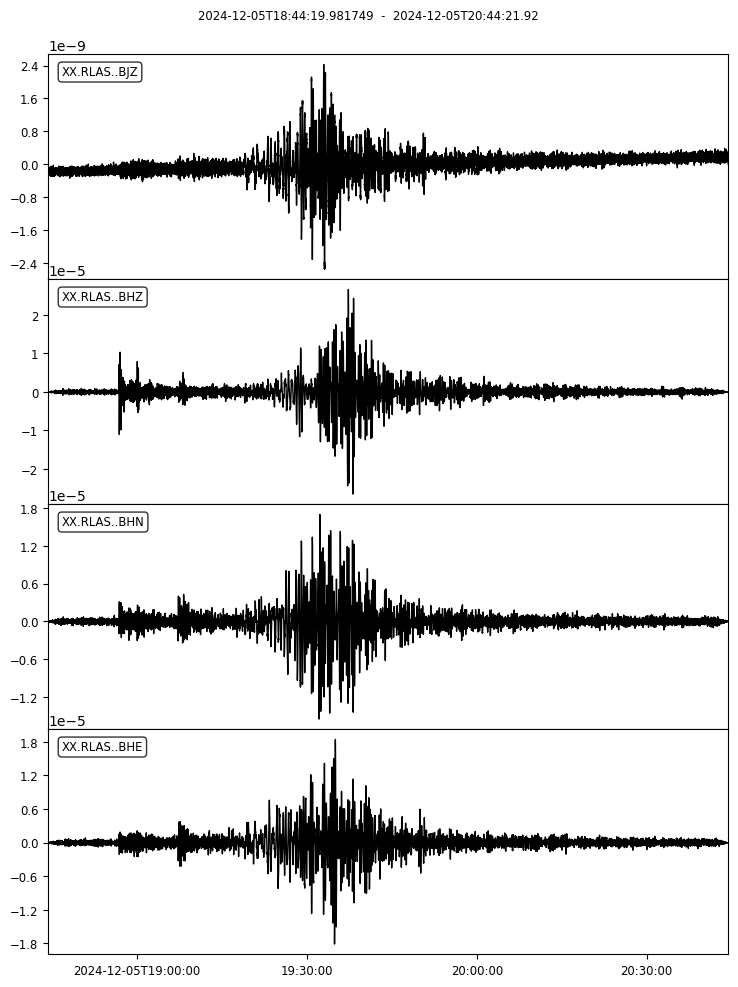

In [8]:
sd.st.plot(equal_scale=False);

In [10]:
sd.trim_stream(set_common=True, set_interpolate=False)

### Write data to file or SDS system

In [10]:
# write to mseed file
# sd.st.write(f"./data/G_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

### Wavelet Comparsion

In [11]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:

    try:
        # Rotation components
        rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
        component = rot_data.stats.channel
        cwt_results[f"{component}"] = sd.compute_cwt(
            rot_data.times(),
            rot_data.data,
            rot_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for rotation")
    try:
        # Translation components
        acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
        component = acc_data.stats.channel
        cwt_results[f"{component}"] = sd.compute_cwt(
            acc_data.times(),
            acc_data.data,
            acc_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for ranslation")


No N data for rotation
No E data for rotation


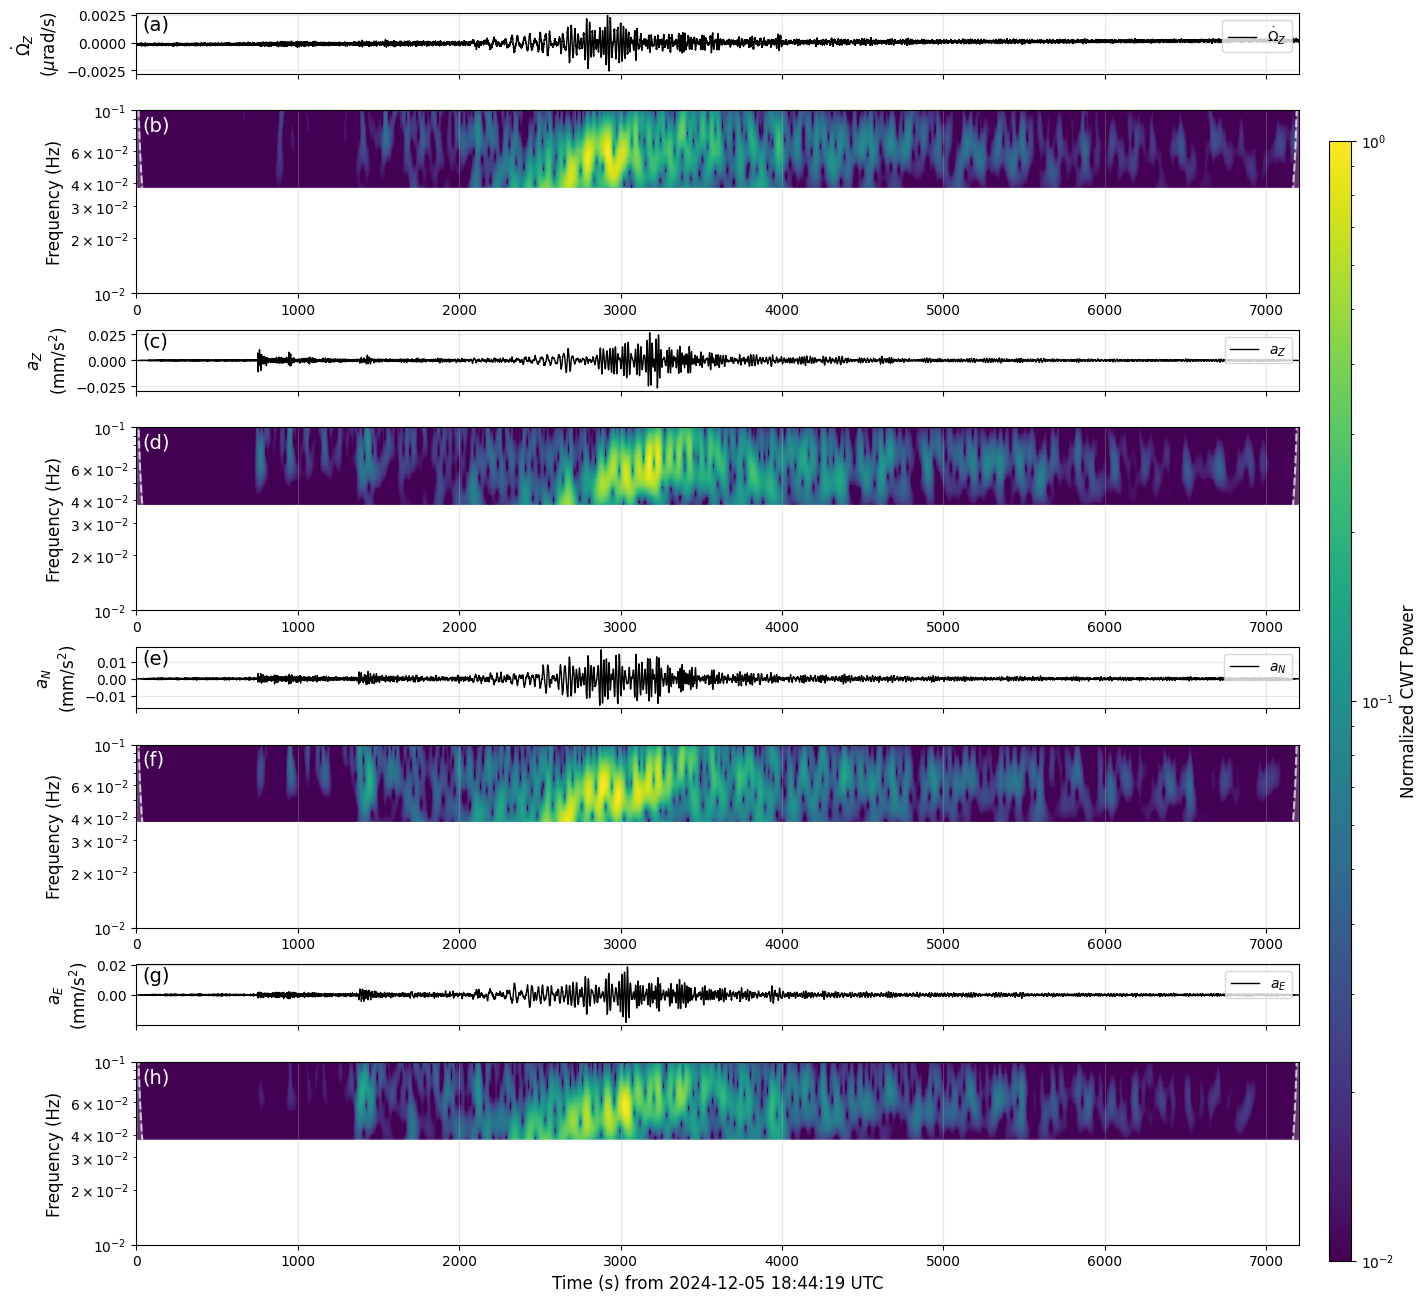

In [12]:
# Then plot all components
fig = plot_cwt_all(
    rot=sd.get_stream("rotation").copy(),
    acc=sd.get_stream("translation").copy(),
    cwt_output=cwt_results,
    clog=True,
    fmin=0.01,
    fmax=0.1
)

del fig

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [13]:
sd.filter_data(fmin=0.01, fmax=0.1, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [14]:
sd.polarity_stream(pol_dict={"HZ": 1, "JZ": 1}, raw=True)

-> polarity already applied. Exiting...


Let's cut to the main event

In [19]:
sd.trim(UTCDateTime(config['tbeg']) + 500, UTCDateTime(config['tend']) - 3000)

Let's compare the waveforms of the rotation (red) and translational (black) components based on the cross-correlation in time windows

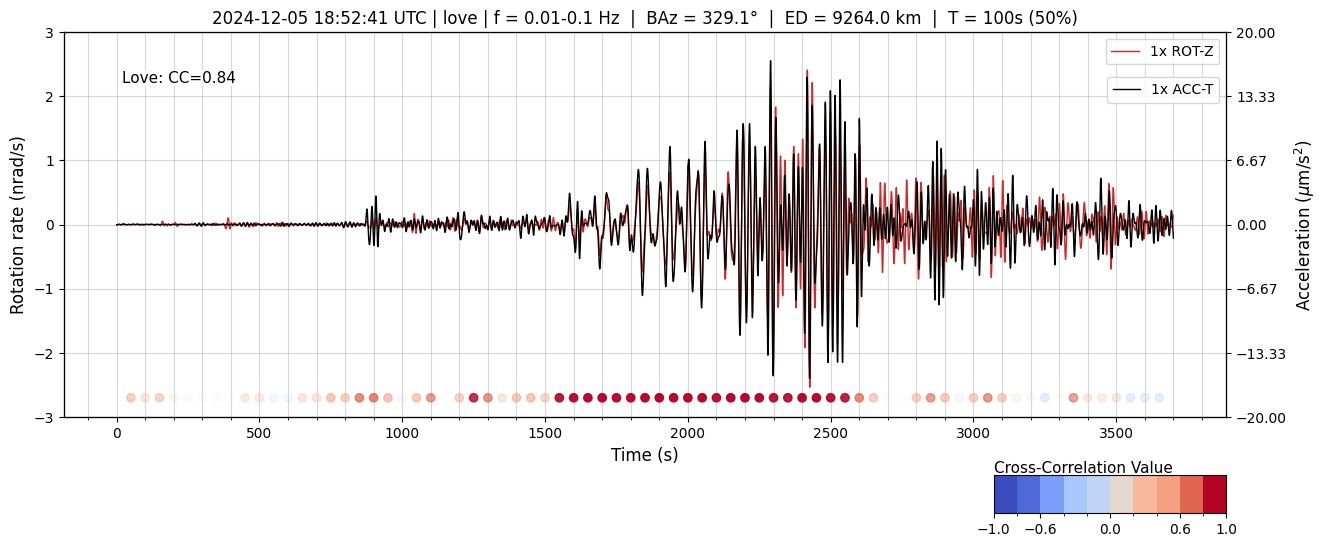

In [20]:
fig = plot_waveform_cc(
    sd_object=sd,
    fmin=sd.fmin, 
    fmax=sd.fmax, 
    twin_sec=100, 
    twin_overlap=0.5,
    wave_type='love',
)

### Backazimuth Estimate

Compute the backazimuth estimates in time windows for Love waves

In [21]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=1,
    baz_win_sec=100,
    baz_win_overlap=0.5,
    out=True
)


Plot the results of the backazimuth estimation using the **midpoint CC approach**

baz_max = 308, baz_std = 28


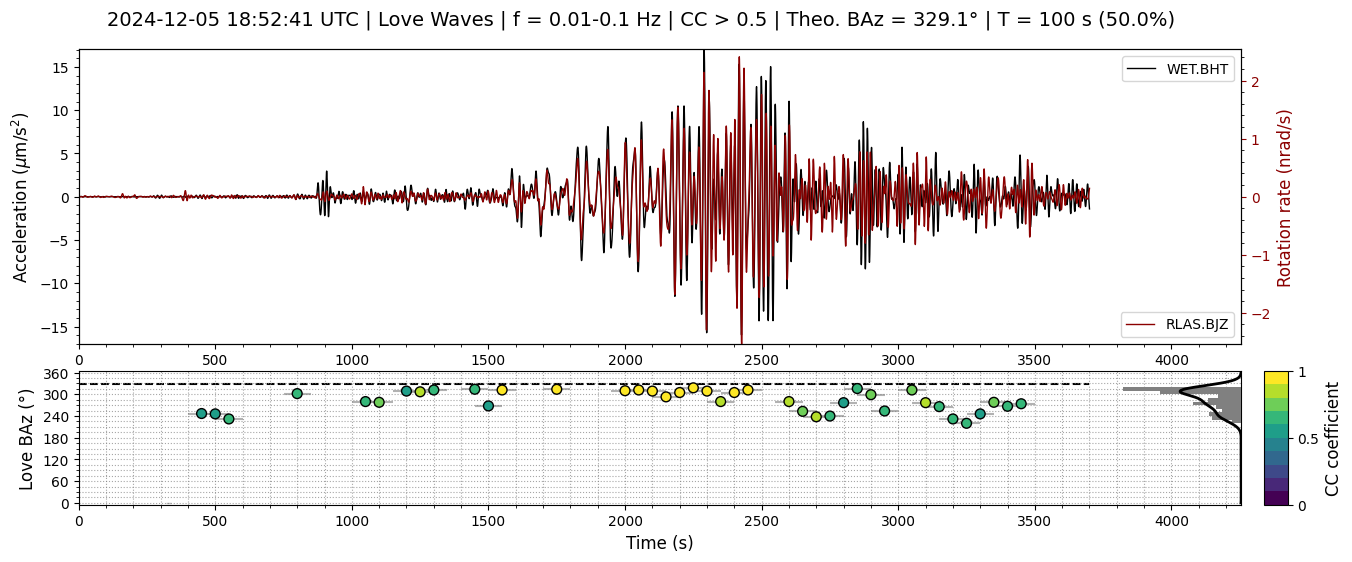

In [24]:

fig = plot_backazimuth_results(
    sd, 
    baz_results,
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,
    cc_method='mid'
)

Plot the results of the backazimuth estimation using the **maximum CC approach**

baz_max = 309, baz_std = 23


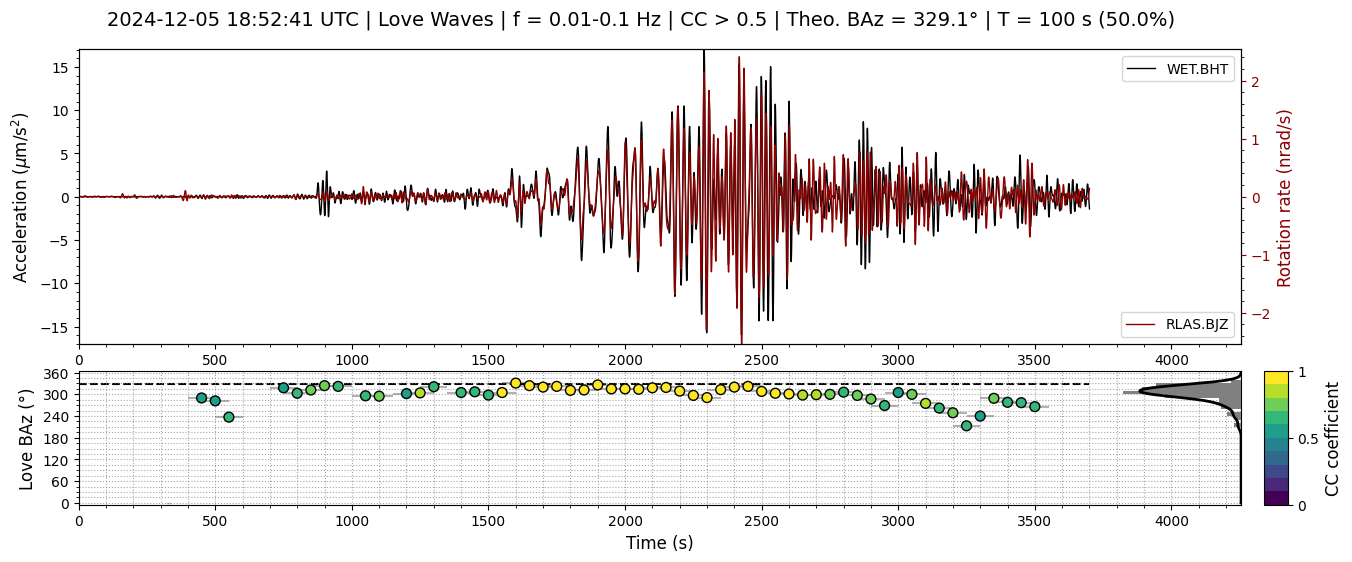

In [25]:

fig = plot_backazimuth_results(
    sd, 
    baz_results,
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,
    cc_method='max'
)

### Analyse phase velocities

Compute the phase velocity estimates in time windows for Love waves using 

1) orthogonal distance regression (ODR)
2) RANdom SAmple Consensus regression (RANSAC)

In [26]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=150.0,
    overlap=0.5,
    cc_threshold=0.,
    method='odr', # odr or ransac
    baz=ev['backazimuth']  # optional
)


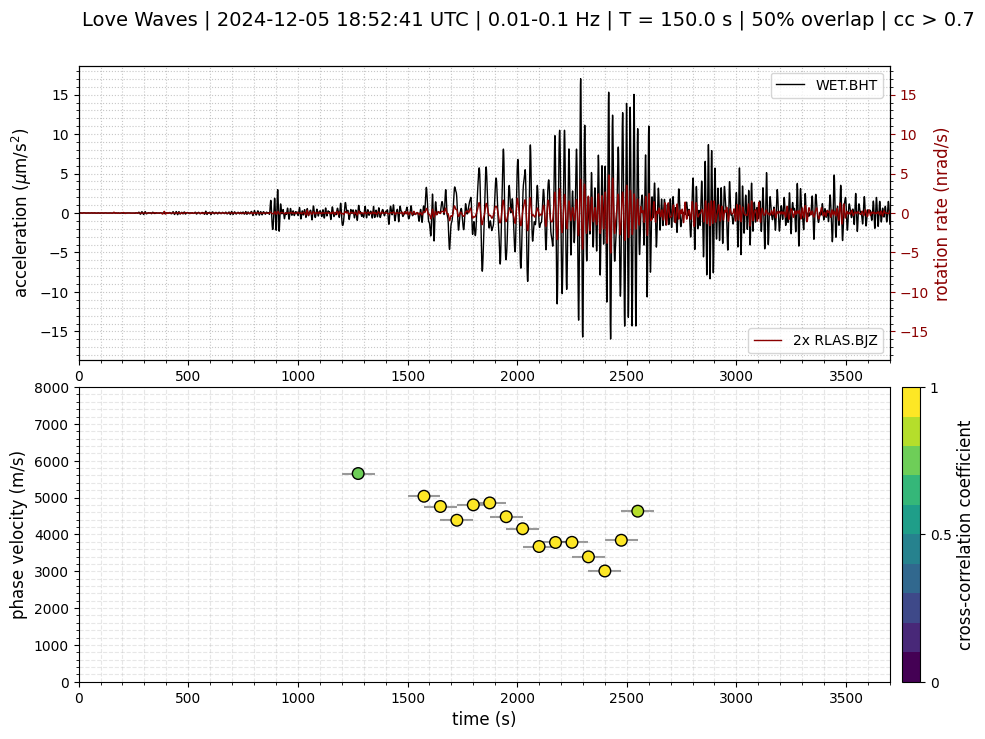

In [28]:
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=8000,  # optional
    minors=True, # optional
    cc_threshold=0.7,
)


In [29]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=150.0,
    overlap=0.5,
    cc_threshold=0.,
    method='ransac', # odr or ransac
    baz=ev['backazimuth']  # optional
)

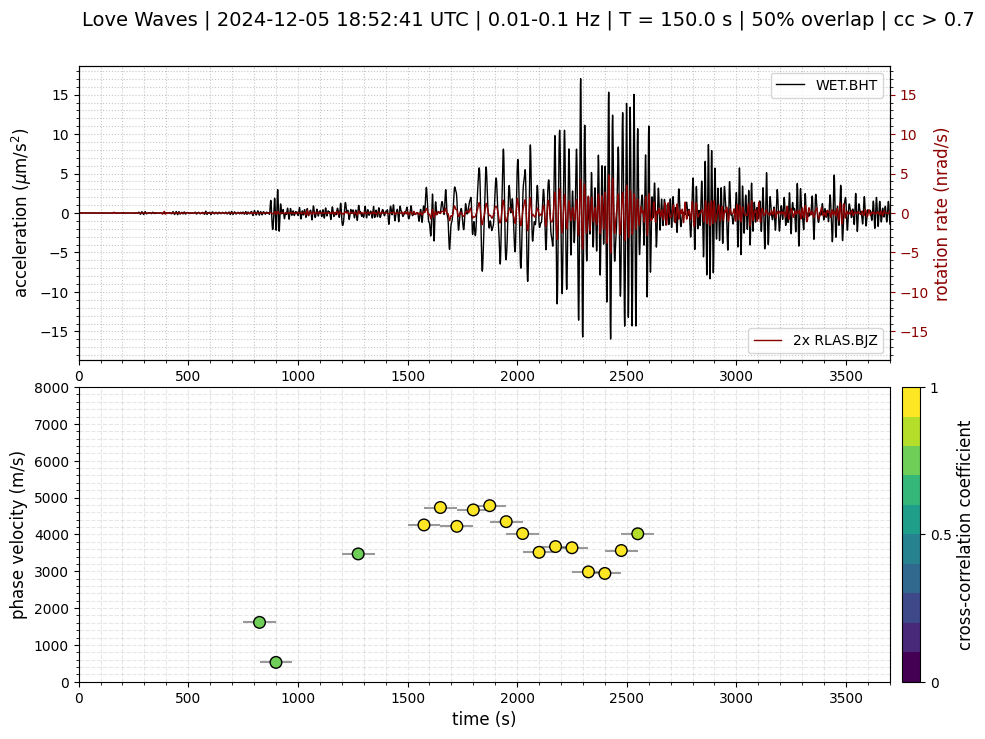

In [30]:
fig = plot_velocities(
    sd,
    velocity_results=love_velocities,
    vmax=8000,  # optional
    minors=True, # optional
    cc_threshold=0.7,
)


In [ ]:
# Compute Love wave velocities with adaptive/optimzed backazimuths per window
love_velocities_optimized = sd.compute_velocities_optimized(
    rotation_data=sd.get_stream("rotation", raw=True),
    translation_data=sd.get_stream("translation", raw=True),
    wave_type='love',
    baz_results=baz_results,
    baz_mode='max',
    method='odr',
    cc_threshold=0.0,
    r_squared_threshold=0.0,
    zero_intercept=True
)

# love_velocities_optimized['parameters']['baz'] = ev['backazimuth']

AttributeError: 'sixdegrees' object has no attribute 'compute_velocities_optimized'

In [ ]:
fig = plot_velocities(
    sd,
    velocity_results=love_velocities_optimized,
    vmax=6000,  # optional
    minors=True, # optional
    cc_threshold=0.7,
)